In [26]:
# KT model

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from rockphypy import EM
import seaborn as sns
from publib import set_style, fix_style
import matplotlib.patheffects as PathEffects
import matplotlib as mpl

# Read the Excel file
df = pd.read_excel('Wallula.xlsx', sheet_name='Filtered_Data_HS')

Km = 80.7167139034238  # Bulk modulus of the matrix
mum = 41.50923084095074  # Shear modulus of the matrix
Kf = 2.1  # Bulk modulus of brine 
mui = 0  # Shear modulus of inclusions 
aspect_ratio = 0.25  # Aspect ratio of the inclusions

# Calculate Pmi and Qmi using rockphypy module
Pmi, Qmi = EM.PQ(Km, mum, 0, mui, aspect_ratio)

# Define the function for zeta_m
def zeta_m(Km, mum):
    return mum * (9*Km + 8*mum) / (6 * (Km + 2*mum))

# Define the system of equations to solve
def equations(vars, x1):
    Keff, mueff = vars
    eq1 = (Keff - Km) - ((Keff + (4*mum)/3) / (Km + (4*mum)/3)) * x1 * (0 - Km) * Pmi
    eq2 = (mueff - mum) - ((mueff + zeta_m(Km, mum)) / (mum + zeta_m(Km, mum))) * x1 * (mui - mum) * Qmi
    return [eq1, eq2]

# Matrix moduli
initial_guess = [Km, mum]

# Lists to store results
Keff_values_KT = []
mueff_values_KT = []

for phi in df["Phi"]:
    x1 = phi  # Volume fraction of inclusions, corresponding to porosity phi
    Keff, mueff = fsolve(equations, initial_guess, args=(x1,))
    #Gassmann's equation to find saturated bulk moduli of rock
    A1 = 1 - (Keff/ Km)
    K_Sat = Keff + (A1 * A1) / ((phi / Kf) + ((1 - phi) / Km) - (Keff / (Km * Km)))

    Keff_values_KT.append(Keff)
    mueff_values_KT.append(mueff)

# Convert lists to numpy arrays for easier plotting and manipulation
Keff_values_KT = np.array(Keff_values_KT)
mueff_values_KT = np.array(mueff_values_KT)


In [27]:
#Berryman SCA model 

# Input matrix moduli
Km1 = [80.7167139034238, 0]  # Bulk modulus of the matrix and inclusion
Gm1 = [41.50923084095074, 0]     # Shear modulus of the matrix and inclusion
a = [1, 0.25]    

# Initialize lists to store calculated Keff and Geff values
Keff_value_SCA = []
Geff_value_SCA = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract phi value for this row
    Phi = row["Phi"]
    
    # Calculate x for this row
    x = [1 - Phi, Phi]
    
    # Calculate K and G for this row
    Keff, Geff = EM.Berryman_sc(Km1, Gm1, x, a)
    #Gassmann's equation to find saturated bulk moduli of rock
    A1 = 1 - (Keff/ Km)
    K_Sat = Keff + (A1 * A1) / ((Phi / 2.1) + ((1 - Phi) / Km) - (Keff / (Km * Km)))
   
    
    # Append calculated Keff and Geff to the lists
    Keff_value_SCA.append(K_Sat)
    Geff_value_SCA.append(Geff)



C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rockphypy\EM.py:517: RuntimeWarning: overflow encountered in multiply
  Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rockphypy\EM.py:507: RuntimeWarning: overflow encountered in multiply
  F2 = 1.0 + A*(1.0 + 1.5*(f + theta) - R*(1.5*f + 2.5*theta)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + theta - R*(f - theta +
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rockphypy\EM.py:517: RuntimeWarning: invalid value encountered in subtract
  Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

In [28]:
Gm = 41.50923084095074
Km = 80.7167139034238
GR =    df['GR']
RHOB = df['RHOB']
Phi = df['Phi']
Sw = df['SW']
# Extract columns
DEP = df['DEPTH']
Vp = df['VP']
Vs = df['VS']
GR = df['GR']
Ki = 0

# Calculate K_log_sat, G_log, D_1, M, sq
K_log_sat = df['K_log']
G_log = df['G_log']
sq=Km*Km
D_1 = (Phi * Km / Kf) + (K_log_sat / Km) - 1 - Phi
M = (((K_log_sat * (((Phi * Km) / Kf) + 1 - Phi)) - Km) / D_1)   # Inverse Gassmann to find K_frame
M[(M < 0)] = np.nan
K_dry_Inv_Gassman = M
#Gassmann's equation to find saturated bulk moduli of rock
A1 = 1 - (K_dry_Inv_Gassman / Km)
Ksat_gassman = K_dry_Inv_Gassman + (A1 * A1) / ((Phi / Kf) + ((1 - Phi) / Km) - (K_dry_Inv_Gassman / sq))     #Gassmann Equation
k_sat_values_gassman =  Ksat_gassman

alp_min = np.zeros(len(df))
K_Sat_DEM_Inverted = np.zeros(len(df))
G_Dry_DEM_Inverted = np.zeros(len(df))
K_Dry_DEM_Inverted = np.zeros(len(df))

def alphafun(alp, Kmat_1, Gmat_1, Phi, Kfl_2):
    thet = np.minimum(alp, 0.99) * (np.arccos(np.minimum(alp, 0.99)) - (np.minimum(alp, 0.99) * np.sqrt(1 - (np.minimum(alp, 0.99) * np.minimum(alp, 0.99))))) / (((1 - np.minimum(alp, 0.99) * np.minimum(alp, 0.99))) ** 1.5)
    g1 = (alp * alp) * (3*thet - 2) / (1 - alp * alp)
    s01 = (2 - 3 * g1 - 3 * thet) / (4 * thet - 4 * g1 - 6 * thet * thet)
    s11 = (thet - g1) / (2 - 3 * g1 - 3 * thet)
    s21 = 4/3
    s31 = 2 * (thet - g1) / (3*(2 * thet - 2 * g1 - 3 * thet * thet))

    #Coeefficients
    f= np.minimum(alp, 0.99)**2*(3.0*thet - 2.0)/(1.0 - np.minimum(alp, 0.99)**2)
    A = Gi/Gmat_1 - 1.0
    B = (Ki/Kmat_1 - Gi/Gmat_1)/3.0
    R = Gmat_1/(Kmat_1 + (4.0/3.0)*Gmat_1) # 
    F1 = 1.0 + A*(1.5*(f + thet) - R*(1.5*f + 2.5*thet - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + thet) - R*(1.5*f + 2.5*thet)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + thet - R*(f - thet + 2.0*thet**2))
    F3 = 1.0 + A*(1.0 - f - 1.5*thet + R*(f + thet))
    F4 = 1.0 + (A/4.0)*(f + 3.0*thet - R*(f - thet))
    F5 = A*(-f + R*(f + thet - 4.0/3.0)) + B*thet*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + thet)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*thet - R*(3.0*f + 5.0*thet)) + B*thet*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (thet/2.0)*(5.0*R - 3.0)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*thet) + B*thet*(3.0 - 4.0*R)
    Tiijj = 3*F1/F2
    Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    P = Tiijj/3
    Q = (Tijij - P)/5


    R_ = -R**2

    F1_ = -A*(( 3* f/2) + (5* thet / 2) - 4 / 3) * R**2
    F2_ = ((-A/2)*(3*f+5*thet) - 4*B + ((A*(A+3*B)/2)) * (-7*f - thet - 6*thet*thet + 8*R*(f-thet + 2*thet*thet)))*R_
    F3_ = (A/2) * ((2 - thet *((1 + alp**2)*f)/ alp**2) * R_)
    F4_ = ((-A / 4) * (f - thet) * R_)
    F5_ = (A * (f+thet-(4/3))-4*B*thet)*R_
    F6_ = (-A*(f+thet) - 4*B*(1- thet))*R_
    F7_ = ((-A/4)*(5*thet+3*f) - 4*B*thet)*R_
    F8_ = (A*(-2+(f/2)+(2.5*thet)) -4*B*(1-thet))*R_
    F9_ = (A*(f-thet) - 4*B*thet)*R_

    # Calculations for T_iijj and T_ijij
    T_iijj_ = (3*(F1_*F2 - F1*F2_))/(2*F2*F2)
    T_ijij_ = ((F1_*F2-F1*F2_)/(F2**2 ))-(2*F3_)/(F3**2) - (F4_)/(F4**2)  + ((F4_*F5 + F4 * F5_ + F6_*F7 + F6*F7_ - F8_* F9 - F8*F9_)*F2*F4 - (F4*F5 + F6*F7 - F8*F9 )*(F2_*F4 + F2*F4_))/(F2*F2*F4*F4 )

    # Calculation for P and Q
    b = (6*T_iijj_)/15 - T_ijij_/5
    a = (P-Q)-(b*Kmat_1)/Gmat_1 
    K_Dry_DEM_Inverted = Kmat_1 * ((1 - Phi) ** (
            s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1))))) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**(s01/b)
    G_Dry_DEM_Inverted = Gmat_1 * ((1 - Phi) ** (
            (s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1)))) + 1.1)) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**((s01/b) - 1)
    A1 = 1 - (K_Dry_DEM_Inverted / Kmat_1)
    A = (A1 * A1) / ((Phi / Kfl_2) + ((1 - Phi) / Kmat_1) - (K_Dry_DEM_Inverted /( Kmat_1 * Kmat_1)))
    K_Sat_DEM_Inverted = K_Dry_DEM_Inverted + A
    return K_Sat_DEM_Inverted, G_Dry_DEM_Inverted, K_Dry_DEM_Inverted

def alphafun1(alp, Kmat_1, Gmat_1, Phi, Kfl_2):
    thet = np.minimum(alp, 0.99) * (np.arccos(np.minimum(alp, 0.99)) - (np.minimum(alp, 0.99) * np.sqrt(1 - (np.minimum(alp, 0.99) * np.minimum(alp, 0.99))))) / (((1 - np.minimum(alp, 0.99) * np.minimum(alp, 0.99))) ** 1.5)
    g1 = (alp * alp) * (3*thet - 2) / (1 - alp * alp)
    s01 = (2 - 3 * g1 - 3 * thet) / (4 * thet - 4 * g1 - 6 * thet * thet)
    s11 = (thet - g1) / (2 - 3 * g1 - 3 * thet)
    s21 = 4/3
    s31 = 2 * (thet - g1) / (3*(2 * thet - 2 * g1 - 3 * thet * thet))

    #Coeefficients
    f= np.minimum(alp, 0.99)**2*(3.0*thet - 2.0)/(1.0 - np.minimum(alp, 0.99)**2)
    A = Gi/Gmat_1 - 1.0
    B = (Ki/Kmat_1 - Gi/Gmat_1)/3.0
    R = Gmat_1/(Kmat_1 + (4.0/3.0)*Gmat_1) # 
    F1 = 1.0 + A*(1.5*(f + thet) - R*(1.5*f + 2.5*thet - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + thet) - R*(1.5*f + 2.5*thet)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + thet - R*(f - thet + 2.0*thet**2))
    F3 = 1.0 + A*(1.0 - f - 1.5*thet + R*(f + thet))
    F4 = 1.0 + (A/4.0)*(f + 3.0*thet - R*(f - thet))
    F5 = A*(-f + R*(f + thet - 4.0/3.0)) + B*thet*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + thet)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*thet - R*(3.0*f + 5.0*thet)) + B*thet*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (thet/2.0)*(5.0*R - 3.0)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*thet) + B*thet*(3.0 - 4.0*R)
    Tiijj = 3*F1/F2
    Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    P = Tiijj/3
    Q = (Tijij - P)/5


    R_ = -R**2

    F1_ = -A*(( 3* f/2) + (5* thet / 2) - 4 / 3) * R**2
    F2_ = ((-A/2)*(3*f+5*thet) - 4*B + ((A*(A+3*B)/2)) * (-7*f - thet - 6*thet*thet + 8*R*(f-thet + 2*thet*thet)))*R_
    F3_ = (A/2) * ((2 - thet *((1 + alp**2)*f)/ alp**2) * R_)
    F4_ = ((-A / 4) * (f - thet) * R_)
    F5_ = (A * (f+thet-(4/3))-4*B*thet)*R_
    F6_ = (-A*(f+thet) - 4*B*(1- thet))*R_
    F7_ = ((-A/4)*(5*thet+3*f) - 4*B*thet)*R_
    F8_ = (A*(-2+(f/2)+(2.5*thet)) -4*B*(1-thet))*R_
    F9_ = (A*(f-thet) - 4*B*thet)*R_

    # Calculations for T_iijj and T_ijij
    T_iijj_ = (3*(F1_*F2 - F1*F2_))/(2*F2*F2)
    T_ijij_ = ((F1_*F2-F1*F2_)/(F2**2 ))-(2*F3_)/(F3**2) - (F4_)/(F4**2)  + ((F4_*F5 + F4 * F5_ + F6_*F7 + F6*F7_ - F8_* F9 - F8*F9_)*F2*F4 - (F4*F5 + F6*F7 - F8*F9 )*(F2_*F4 + F2*F4_))/(F2*F2*F4*F4 )

    # Calculation for P and Q
    b = (6*T_iijj_)/15 - T_ijij_/5
    a = (P-Q)-(b*Kmat_1)/Gmat_1 
    K_Dry_DEM_Inverted = Kmat_1 * ((1 - Phi) ** (
            s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1))))) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**(s01/b)
    G_Dry_DEM_Inverted = Gmat_1 * ((1 - Phi) ** (
            (s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1)))) + 1.1)) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**((s01/b) - 1)
    A1 = 1 - (K_Dry_DEM_Inverted / Kmat_1)
    A = (A1 * A1) / ((Phi / Kfl_2) + ((1 - Phi) / Kmat_1) - (K_Dry_DEM_Inverted /( Kmat_1 * Kmat_1)))
    K_Sat_DEM_Inverted = K_Dry_DEM_Inverted + A
    return K_Sat_DEM_Inverted

def alphafun2(alp, Kmat_1, Gmat_1, Phi, Kfl_2):
    thet = np.minimum(alp, 0.99) * (np.arccos(np.minimum(alp, 0.99)) - (np.minimum(alp, 0.99) * np.sqrt(1 - (np.minimum(alp, 0.99) * np.minimum(alp, 0.99))))) / (((1 - np.minimum(alp, 0.99) * np.minimum(alp, 0.99))) ** 1.5)
    g1 = (alp * alp) * (3*thet - 2) / (1 - alp * alp)
    s01 = (2 - 3 * g1 - 3 * thet) / (4 * thet - 4 * g1 - 6 * thet * thet)
    s11 = (thet - g1) / (2 - 3 * g1 - 3 * thet)
    s21 = 4/3
    s31 = 2 * (thet - g1) / (3*(2 * thet - 2 * g1 - 3 * thet * thet))

    #Coeefficients
    f= np.minimum(alp, 0.99)**2*(3.0*thet - 2.0)/(1.0 - np.minimum(alp, 0.99)**2)
    A = Gi/Gmat_1 - 1.0
    B = (Ki/Kmat_1 - Gi/Gmat_1)/3.0
    R = Gmat_1/(Kmat_1 + (4.0/3.0)*Gmat_1) # 
    F1 = 1.0 + A*(1.5*(f + thet) - R*(1.5*f + 2.5*thet - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + thet) - R*(1.5*f + 2.5*thet)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + thet - R*(f - thet + 2.0*thet**2))
    F3 = 1.0 + A*(1.0 - f - 1.5*thet + R*(f + thet))
    F4 = 1.0 + (A/4.0)*(f + 3.0*thet - R*(f - thet))
    F5 = A*(-f + R*(f + thet - 4.0/3.0)) + B*thet*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + thet)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*thet - R*(3.0*f + 5.0*thet)) + B*thet*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (thet/2.0)*(5.0*R - 3.0)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*thet) + B*thet*(3.0 - 4.0*R)
    Tiijj = 3*F1/F2
    Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    P = Tiijj/3
    Q = (Tijij - P)/5


    R_ = -R**2

    F1_ = -A*(( 3* f/2) + (5* thet / 2) - 4 / 3) * R**2
    F2_ = ((-A/2)*(3*f+5*thet) - 4*B + ((A*(A+3*B)/2)) * (-7*f - thet - 6*thet*thet + 8*R*(f-thet + 2*thet*thet)))*R_
    F3_ = (A/2) * ((2 - thet *((1 + alp**2)*f)/ alp**2) * R_)
    F4_ = ((-A / 4) * (f - thet) * R_)
    F5_ = (A * (f+thet-(4/3))-4*B*thet)*R_
    F6_ = (-A*(f+thet) - 4*B*(1- thet))*R_
    F7_ = ((-A/4)*(5*thet+3*f) - 4*B*thet)*R_
    F8_ = (A*(-2+(f/2)+(2.5*thet)) -4*B*(1-thet))*R_
    F9_ = (A*(f-thet) - 4*B*thet)*R_

    # Calculations for T_iijj and T_ijij
    T_iijj_ = (3*(F1_*F2 - F1*F2_))/(2*F2*F2)
    T_ijij_ = ((F1_*F2-F1*F2_)/(F2**2 ))-(2*F3_)/(F3**2) - (F4_)/(F4**2)  + ((F4_*F5 + F4 * F5_ + F6_*F7 + F6*F7_ - F8_* F9 - F8*F9_)*F2*F4 - (F4*F5 + F6*F7 - F8*F9 )*(F2_*F4 + F2*F4_))/(F2*F2*F4*F4 )

    # Calculation for P and Q
    b = (6*T_iijj_)/15 - T_ijij_/5
    a = (P-Q)-(b*Kmat_1)/Gmat_1 
    K_Dry_DEM_Inverted = Kmat_1 * ((1 - Phi) ** (
            s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1))))) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**(s01/b)
    G_Dry_DEM_Inverted = Gmat_1 * ((1 - Phi) ** (
            (s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1)))) + 1.1)) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**((s01/b) - 1)
    A1 = 1 - (K_Dry_DEM_Inverted / Kmat_1)
    A = (A1 * A1) / ((Phi / Kfl_2) + ((1 - Phi) / Kmat_1) - (K_Dry_DEM_Inverted /( Kmat_1 * Kmat_1)))
    K_Sat_DEM_Inverted = K_Dry_DEM_Inverted + A
    return G_Dry_DEM_Inverted

alpha = 0.25  # Example aspect ratio of the inclusion phase
Gi = 0
# Initialize dictionaries to store K and G values for each alpha
K_Sat_Num_DEM = []
G_Num_DEM = []

alp = 0.25
K_Sat_DEM, G_dry_DEM, K_dry_DEM = alphafun(alp, Km, Gm, Phi, Kf)


In [29]:
# SCA-DEM

# Extract columns
plg = 51.78
qtz = 11.48
ort = 6.96
hem = 7.09
dio = 9.40
sph = 3.50
hyp = 7.55
apt = 0.73
total_sum = plg + qtz + ort + hem + dio + sph + hyp + apt

# Normalize variables
plg = plg / total_sum
qtz = qtz / total_sum
ort = ort / total_sum
hem = hem / total_sum
dio = dio / total_sum
sph = sph / total_sum
hyp = hyp / total_sum
apt = apt / total_sum


means = [plg, qtz, ort, hem, dio, sph, hyp, apt]

# Round to 2 decimal places
rounded_means = [round(mean, 3) for mean in means]

# Adjust the last value to ensure the sum is exactly 1
rounded_sum = sum(rounded_means)
if rounded_sum != 1:
    difference = 1 - rounded_sum
    rounded_means[-1] = round(rounded_means[-1] + difference, 2)

# Assign rounded values back to variables
plg, qtz, ort, hem, dio, sph, hyp, apt = rounded_means

# Bulk and shear moduli of minerals (Rock Physics Handbook by Tapan Mukerji)
Kplg = 79.5
Gplg = 33.8

Kqtz = 37
Gqtz = 44

Khyp = 101 
Ghyp = 52   

Kort = 46.8  
Gort = 27.3   

Khem = 206.6  
Ghem = 91   

Kdio = 111.2  
Gdio = 63.7  

Ksph = 131.4  
Gsph = 52  

Kapt = 80.65  
Gapt = 47.2  

In [30]:

# Inpts
Km = [79.5,111.2,37,101,206.6,46.8,131.4,80.65]  # Bulk modulus of the matrix
Gm = [33.8,63.7,44,52,91,48.3,52,47.2]     # Shear modulus of the matrix
a = [1,1,1,1,1,1,1,1]    # Packing factor

# Initialize lists to store calculated Keff and Geff values
Keff_values = []
Geff_values = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract phi value for this row
    Phi = row["Phi"]
    
    # Calculate x for this row
    x = [0.526,0.095,0.117,0.077,0.072,0.071,0.036,0.01]
    
    # Calculate K and G for this row
    Keff, _ = EM.Berryman_sc(Km, Gm, x, a)
    Geff, _ = EM.Berryman_sc(Gm, Km, x, a)
    
    # Append calculated Keff and Geff to the lists
    Keff_values.append(Keff)
    Geff_values.append(Geff)

# Add Keff and Geff values to the DataFrame
df['Keff'] = Keff_values
df['Geff'] = Geff_values
print(f"Matrix bulk moduli caluclated using SCA: {Keff}")
print(f"Matrix shear moduli caluclated using SCA: {Geff}")


Matrix bulk moduli caluclated using SCA: 80.26303652390821
Matrix shear moduli caluclated using SCA: 44.08071495866107


In [31]:

Gm = Geff
Km = Keff

Phi = df['Phi']

alpha = 0.25  # aspect ratio of the inclusion phase
Ki = 0  # bulk modulus of inclusion
Gi = 0    #shear modulus of inclusion

# Initialize dictionaries to store K and G values for each alpha
K_Sat_Num_SCA_DEM = []
G_Num_SCA_DEM = []

K_Sat_SCA_DEM, G_dry_SCA_DEM, K_dry_SCA_DEM = alphafun(alpha, Km, Gm, Phi, Kf)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17724\1941670034.py:64: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  plt.legend(handles=existing_legend.legendHandles + legend_patches, fontsize=18)


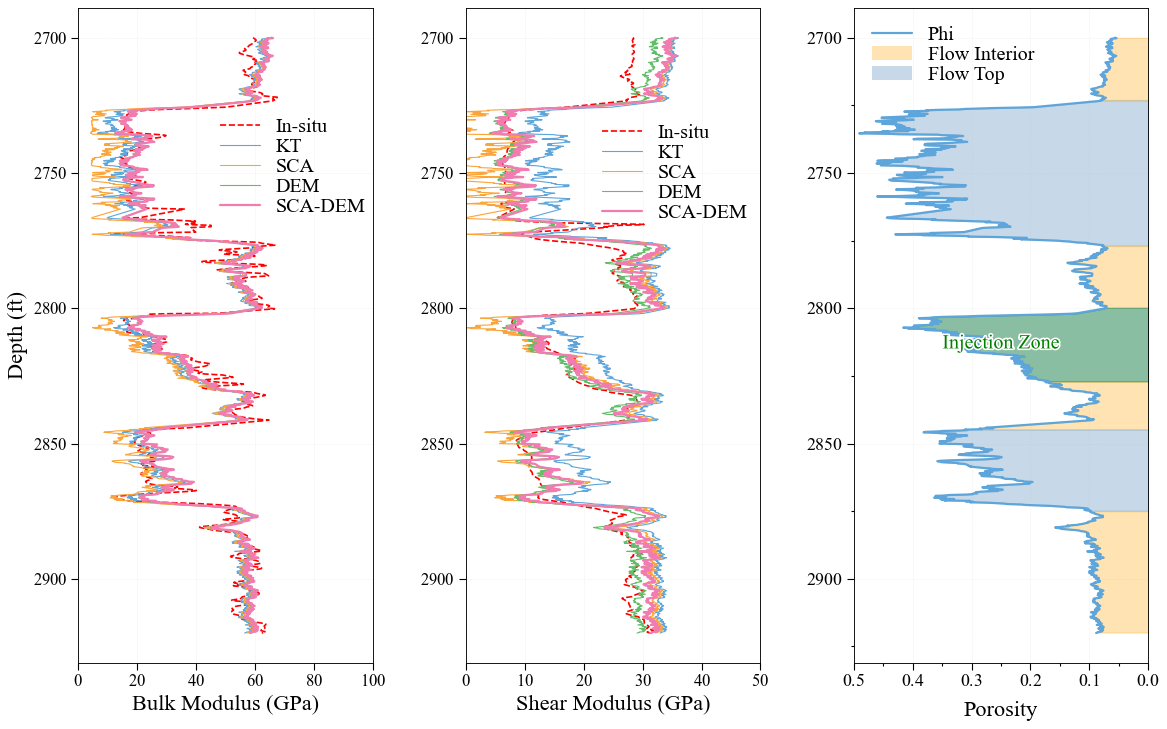

In [32]:
#Plotting predicted elastic with in-situ elastic moduli

set_style("article")
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.plot(K_log_sat, DEP, label='In-situ', color='red', linestyle='--', linewidth=1.5)  # Red dashed line with increased thickness
plt.plot(Keff_values_KT, DEP, label='KT', linewidth=1)
plt.plot(Keff_value_SCA, DEP, label='SCA', linewidth=1)
plt.plot(K_Sat_DEM, DEP, label='DEM', linewidth=1)
plt.plot(K_Sat_SCA_DEM, DEP, label='SCA-DEM')
plt.gca().invert_yaxis()
plt.xlim(0, 100)
plt.xlabel('Bulk Modulus (GPa)', fontsize=20)
plt.ylabel('Depth (ft)', fontsize=20)
plt.legend(loc='best', fontsize=18, framealpha=1,bbox_to_anchor=(0.42, 0.86))
plt.grid(True)

# Shear Modulus Plot
plt.subplot(1, 3, 2)
plt.plot(G_log, DEP, label='In-situ', color='red', linestyle='--', linewidth=1.5)  # Red dashed line with increased thickness
plt.plot(mueff_values_KT, DEP, label='KT', linewidth=1)
plt.plot(Geff_value_SCA, DEP, label='SCA', linewidth=1)
plt.plot(G_dry_DEM, DEP, label='DEM', linewidth=1)
plt.plot(G_dry_SCA_DEM, DEP, label='SCA-DEM')
plt.gca().invert_yaxis()
plt.xlabel('Shear Modulus (GPa)', fontsize=20)
plt.legend(loc='upper left', fontsize=18, framealpha=1,bbox_to_anchor=(0.4, 0.85))
plt.xlim(0, 50)
plt.grid(True)

# Your plotting code
plt.subplot(1, 3, 3)
plt.plot(df["Phi"], df["DEPTH"], label='Phi', linestyle='-')
plt.gca().invert_yaxis()
plt.xlabel('Porosity', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left', fontsize=18, framealpha=1)

#Depth of flow interior and flow top zones
marker_depths = [2700, 2723.1, 2776.9, 2799.8, 2827.1, 2844.8, 2875, 2920]
# Adding lines at specified depths with alternating colors
for i in range(len(marker_depths) - 1):
    start_depth = marker_depths[i]
    end_depth = marker_depths[i + 1]
    color = 'orange' if i % 2 == 0 else 'steelblue'  # Alternate colors between red and blue
    plt.fill_betweenx(df["DEPTH"], df["Phi"], where=((df["DEPTH"] >= start_depth) & (df["DEPTH"] <= end_depth)), color=color, alpha=0.3)

# Highlighting the Injection Zone
plt.fill_betweenx(df["DEPTH"], df["Phi"], where=((df["DEPTH"] >= 2799.8) & (df["DEPTH"] <= 2827.1)), color='green', alpha=0.3)

# Adding glow effect to the text
injection_text = plt.text(0.25, 2813, "Injection Zone", fontsize=18, color='green', verticalalignment='center', horizontalalignment='center')
injection_text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground="white")])

# Custom legend entries
legend_colors = {'orange': 'Flow Interior','steelblue': 'Flow Top'}
legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=color, edgecolor='none', alpha=0.3, label=label) for color, label in legend_colors.items()]

# Add the custom legend entries to the existing NPHI legend
existing_legend = plt.legend(loc='upper left', fontsize=18)  # Existing NPHI legend
plt.legend(handles=existing_legend.legendHandles + legend_patches, fontsize=18)
plt.xlim(0.5, 0)

fix_style("article")
plt.show()

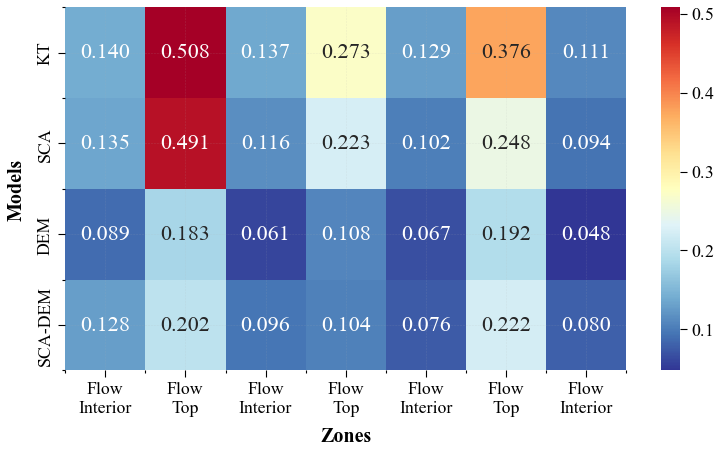

In [33]:
#Heatmap of Normalized Mean Absolute Error for different RPM
set_style("article")
dn = pd.DataFrame({
    "DEPTH" : df["DEPTH"],
    'K_log' : K_log_sat,
    'G_log' : G_log,
    'Keff_values_KT': Keff_values_KT,
    'mueff_values_KT': mueff_values_KT,
    'Keff_value_SCA': Keff_value_SCA,
    'Geff_value_SCA': Geff_value_SCA,
    'K_Sat_DEM': K_Sat_DEM,
    'G_dry_DEM': G_dry_DEM,
    'K_Sat_SCA_DEM': K_Sat_SCA_DEM,
    'G_dry_SCA_DEM': G_dry_SCA_DEM
})
# Define the calculate_nmae function
def calculate_nmae(predicted_curve, observed_curve):
    mae = np.mean(np.abs(predicted_curve - observed_curve))
    mean_observed = np.mean(observed_curve)
    nmae = mae / mean_observed
    return nmae


# Depth markers for zones
depth_markers = [2700, 2723.1, 2776.9, 2799.8, 2827.1, 2844.8, 2875, 2920] 
dn.set_index('DEPTH', inplace=True)

# Calculate nmae for different zones
nmae_results = {}

for i in range(len(depth_markers) - 1):
    depth_range = (depth_markers[i], depth_markers[i + 1])
    depth_mask = (dn.index >= depth_range[0]) & (dn.index < depth_range[1])
    
    K_log_sat_zone = dn.loc[depth_mask, "K_log"].values
    G_log_zone = dn.loc[depth_mask, "G_log"].values
    
    Keff_values_KT_zone = dn.loc[depth_mask, "Keff_values_KT"].values
    mueff_values_KT_zone = dn.loc[depth_mask, "mueff_values_KT"].values
    
    Keff_value_SCA_zone = dn.loc[depth_mask, "Keff_value_SCA"].values
    Geff_value_SCA_zone = dn.loc[depth_mask, "Geff_value_SCA"].values
    
    K_Sat_DEM_zone = dn.loc[depth_mask, "K_Sat_DEM"].values
    G_dry_DEM_zone = dn.loc[depth_mask, "G_dry_DEM"].values
    
    K_Sat_SCA_DEM_zone = dn.loc[depth_mask, "K_Sat_SCA_DEM"].values
    G_dry_SCA_DEM_zone = dn.loc[depth_mask, "G_dry_SCA_DEM"].values
    
    nmae_KT_K_zone = (calculate_nmae(Keff_values_KT_zone, K_log_sat_zone) + 
                       calculate_nmae(mueff_values_KT_zone, G_log_zone)) / 2
    
    nmae_SCA_K_zone = (calculate_nmae(Keff_value_SCA_zone, K_log_sat_zone) + 
                        calculate_nmae(Geff_value_SCA_zone, G_log_zone)) / 2
    
    nmae_K_DEM_K_zone = (calculate_nmae(K_Sat_DEM_zone, K_log_sat_zone) + 
                          calculate_nmae(G_dry_DEM_zone, G_log_zone)) / 2
    
    nmae_K_SCA_DEM_K_zone = (calculate_nmae(K_Sat_SCA_DEM_zone, K_log_sat_zone) + 
                              calculate_nmae(G_dry_SCA_DEM_zone, G_log_zone)) / 2
    
    zone_name = f"Zone_{i + 1}"
    nmae_results[zone_name] = {
        'KT': nmae_KT_K_zone,
        'SCA': nmae_SCA_K_zone,
        'DEM': nmae_K_DEM_K_zone,
        'SCA-DEM': nmae_K_SCA_DEM_K_zone
    }
# Create a heatmap plot
model_names = ['KT', 'SCA', 'DEM', 'SCA-DEM']
zone_labels = ['Flow\nInterior','Flow\nTop'] * ((len(depth_markers) - 1) // 2) + (['Flow\nInterior'] if (len(depth_markers) - 1) % 2 != 0 else [])
nmae_data = np.zeros((len(model_names), len(zone_labels)))

for i, zone_name in enumerate([f"Zone_{i + 1}" for i in range(len(depth_markers) - 1)]):
    nmae_data[0, i] = nmae_results[zone_name]['KT']
    nmae_data[1, i] = nmae_results[zone_name]['SCA']
    nmae_data[2, i] = nmae_results[zone_name]['DEM']
    nmae_data[3, i] = nmae_results[zone_name]['SCA-DEM']

plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(nmae_data, annot=True, cmap="RdYlBu_r", vmin=np.nanmin(nmae_data), vmax=np.nanmax(nmae_data), 
            xticklabels=zone_labels, yticklabels=model_names, fmt='.3f')
# Set title with fontsize

# Set xlabel and ylabel with fontsize
plt.xlabel('Zones', fontsize=18, fontweight='bold')
plt.ylabel('Models', fontsize=18, fontweight='bold')

# Set tick labels fontsize
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set color bar label fontsize
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.tight_layout()
fix_style("article")
plt.show()



In [34]:
# Normalized Mean Absolute Error for bulk and shear moduli of different RPM
set_style("article")
def calculate_metrics(y_true, y_pred):
    # Calculate nmae and R-squared
    mae = np.mean(np.abs(y_pred - y_true))
    mean_observed = np.mean(y_true)
    nmae = mae / mean_observed
    r2 = np.corrcoef(y_true, y_pred)[0, 1] ** 2
    # print(y_true - y_pred)
    return nmae, r2

min_length = min(len(Keff_values_KT), len(K_log_sat))
# Calculate nmae and R-squared for KT
nmae_KT_K, r2_KT_K = calculate_metrics(Keff_values_KT[:min_length], K_log_sat[:min_length])
# Calculate nmae and R-squared for KT
nmae_KT_G, r2_KT_G = calculate_metrics(mueff_values_KT[:min_length], G_log[:min_length])


# Calculate nmae and R-squared for SCA
nmae_SCA_K, r2_SCA_K = calculate_metrics(Keff_value_SCA[:min_length], K_log_sat[:min_length])
# Calculate nmae and R-squared for SCA
nmae_SCA_G, r2_SCA_G = calculate_metrics(Geff_value_SCA[:min_length], G_log[:min_length])


# Calculate nmae and R-squared for Li Zhang DEM
nmae_DEM_K, r2_DEM_K = calculate_metrics(K_Sat_DEM[:min_length], K_log_sat[:min_length])
# Calculate nmae and R-squared for Li Zhang DEM
nmae_DEM_G, r2_DEM_G = calculate_metrics(G_dry_DEM[:min_length], G_log[:min_length])



# Calculate nmae and R-squared for Numerical DEM
nmae_SCADEM_K, r2_SCADEM_K = calculate_metrics(K_Sat_SCA_DEM[:min_length], K_log_sat[:min_length])
# Calculate nmae and R-squared for Numerical DEM
nmae_SCADEM_G, r2_SCADEM_G = calculate_metrics(G_dry_SCA_DEM[:min_length], G_log[:min_length])


# Create lists for nmae and R-squared
variables = ['KT (K)', 'KT (G)', 'SCA (K)', 'SCA (G)', 'DEM (K)', 'DEM (G)', "SCA-DEM (K)", "SCA-DEM (G)"]

nmae_values = [nmae_KT_K, nmae_KT_G, nmae_SCA_K, nmae_SCA_G, nmae_DEM_K, nmae_DEM_G, nmae_SCADEM_K, nmae_SCADEM_G]


# Print nmae values for K and G for each model
print(f"nmae for KT (K): {nmae_KT_K:.3f}")
print(f"nmae for KT (G): {nmae_KT_G:.3f}")
print(f"nmae for SCA (K): {nmae_SCA_K:.3f}")
print(f"nmae for SCA (G): {nmae_SCA_G:.3f}")
print(f"nmae for DEM (K): {nmae_DEM_K:.3f}")
print(f"nmae for DEM (G): {nmae_DEM_G:.3f}")
print(f"nmae for SCADEM (K): {nmae_SCADEM_K:.3f}")
print(f"nmae for SCADEM (G): {nmae_SCADEM_G:.3f}")


nmae for KT (K): 0.106
nmae for KT (G): 0.232
nmae for SCA (K): 0.154
nmae for SCA (G): 0.193
nmae for DEM (K): 0.088
nmae for DEM (G): 0.091
nmae for SCADEM (K): 0.088
nmae for SCADEM (G): 0.131


In [35]:
# nmae values for each model and modulus
nmae_values = {
    "KT_K": nmae_KT_K,
    "KT_G": nmae_KT_G,
    "SCA_K": nmae_SCA_K,
    "SCA_G": nmae_SCA_G,
    "DEM_K": nmae_DEM_K,
    "DEM_G": nmae_DEM_G,
    "SCADEM_K": nmae_SCADEM_K,
    "SCADEM_G": nmae_SCADEM_G
}

# Calculate percentage improvement for K and G separately
improvement_K = {
    model: ((nmae_values[model] - nmae_values["DEM_K"]) / nmae_values[model]) * 100
    for model in nmae_values if "K" in model and model != "DEM_K"
}

improvement_G = {
    model: ((nmae_values[model] - nmae_values["DEM_G"]) / nmae_values[model]) * 100
    for model in nmae_values if "G" in model and model != "DEM_G"
}

# Print results
print("Percentage Improvement of DEM for K compared to other models:")
for model, improvement_value in improvement_K.items():
    print(f"{model}: {improvement_value:.4f}%")

print("\nPercentage Improvement of DEM for G compared to other models:")
for model, improvement_value in improvement_G.items():
    print(f"{model}: {improvement_value:.4f}%")

Percentage Improvement of DEM for K compared to other models:
KT_K: 17.4535%
KT_G: 62.1919%
SCA_K: 43.0651%
SCADEM_K: 0.0059%

Percentage Improvement of DEM for G compared to other models:
KT_G: 60.8340%
SCA_G: 52.9296%
SCADEM_G: 30.4189%


In [36]:
# Average nmae for each model
avg_nmae = {
    "KT": (nmae_values["KT_K"] + nmae_values["KT_G"]) / 2,
    "SCA": (nmae_values["SCA_K"] + nmae_values["SCA_G"]) / 2,
    "DEM": (nmae_values["DEM_K"] + nmae_values["DEM_G"]) / 2,
    "SCADEM": (nmae_values["SCADEM_K"] + nmae_values["SCADEM_G"]) / 2
}

# Percentage improvement of DEM compared to other models
improvement = {
    model: ((avg_nmae[model] - avg_nmae["DEM"]) / avg_nmae[model]) * 100
    for model in avg_nmae if model != "DEM"
}

# Print results
print("Percentage Improvement of DEM over other models:")
for model, improvement_value in improvement.items():
    print(f"{model}: {improvement_value:.2f}%")

Percentage Improvement of DEM over other models:
KT: 47.21%
SCA: 48.55%
SCADEM: 18.20%
